# Training U-Net model for coastline semantic segmentation using PyTorch

In [1]:
#Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
import glob

import cv2 as cv
from PIL import Image
from osgeo import gdal

import torch 
import torch.nn as nn

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from train_unet import * #load dataset and model classes

fig_path = '/Users/conorosullivan/Google Drive/My Drive/UCD/research/Interpreting UNet/Figures/{}.png'

In [2]:
def get_rgb(img):
    """Return normalized RGB channels from sentinal image"""
    img = np.array(img)
    rgb_img = np.stack([img[3],img[2],img[1]],axis=-1)

    for i in range(3):
        rgb_img[:,:,i] = (rgb_img[:,:,i] - np.min(rgb_img[:,:,i]))/(np.max(rgb_img[:,:,i]) - np.min(rgb_img[:,:,i]))

    rgb_normalize = np.clip(rgb_img, 0, 0.3)/0.3
    
    return rgb_normalize

## Load test dataset and model

In [3]:
paths = glob.glob("../../data/SWED/test/images/*")
print(len(paths))
paths[0]

98


'../../data/SWED/test/images/S2A_MSIL2A_20191105T023901_N0213_R089_T50RPN_20191105T062756_image_0_0.tif'

In [23]:
# Load dataset
TRANSFORMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

paths = glob.glob("../../data/SWED/test/images/*")

test_data = TrainDataset(paths, TRANSFORMS,scale=False)
test_loader = DataLoader(test_data, batch_size=test_data.__len__())

print(test_data.__len__())

98


In [24]:
# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

# Load saved model 
model = torch.load('../../models/UNET-NOSCALE-16FEB23.pth', map_location=torch.device('cpu') )
model.eval()
model.to(device)

Using device: mps



build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 

# Evaluate model

In [25]:
images, target = next(iter(test_loader))

images = images.to(device)

# Get model predictions
output = model(images)
print(output.shape)

# Get model predictions 
preds = [np.round(out) for out in output.cpu().detach()]
preds = [np.array(pred[0]) for pred in preds]
target = [np.array(t) for t in target] #format target


torch.Size([98, 1, 256, 256])


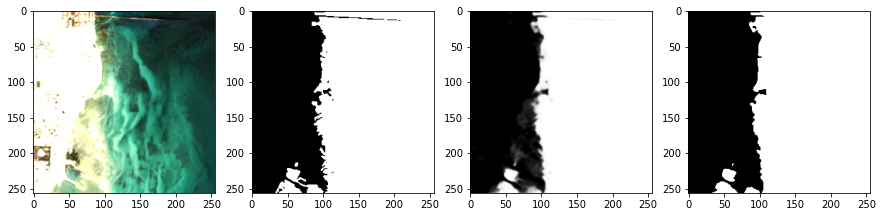

In [52]:
# Display images and predictions
rint = np.random.randint(0, len(output))

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(get_rgb(images[rint].cpu()), cmap='gray')
ax[1].imshow(target[rint], cmap='gray')
ax[2].imshow(output[rint][0].cpu().detach(), cmap='gray')
ax[3].imshow(preds[rint], cmap='gray')

MODEL EVALUATION
Overall accuracy: 0.801869450783243
0.801869450783243


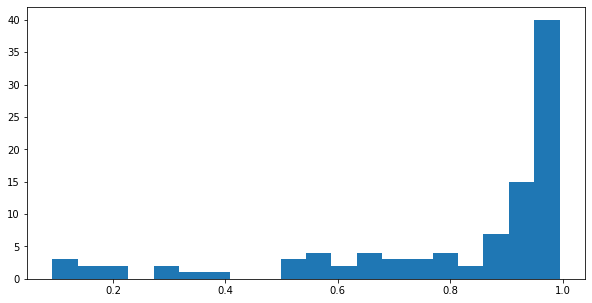

In [49]:
def eval(target, preds):
    """Evaluate model performance on test set"""
    print("MODEL EVALUATION\n================")

    # Calcualte accuracy

    correct = 0
    total = 0
    accuracy = []
    for i in range(len(target)):

        
        correct_i = np.sum(target[i] == preds[i])
        h,w = target[i].shape
        total_i = h*w

        acc = correct_i/total_i

        #add accuracy for each image
        accuracy.append(acc)

        #update overall accuracy numerator and denominator
        correct += correct_i
        total += total_i

    overall_acc = correct/total
    print("Overall accuracy: {}".format(overall_acc))

    return accuracy

accuracy = eval(target, preds)

# Plot accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(accuracy, bins=20)
print(np.mean(accuracy))

In [50]:
accuracy = [calc_accuracy(pred,mask) for pred, mask in zip(predictions,targets)]
print(np.mean(accuracy))

plt.figure(figsize=(10,6))
sns.boxplot(y=accuracy)

NameError: name 'predictions' is not defined

# Interpreting model output

### Permutation feature importance 

In [171]:
def shuffle_band(band):
    perm_image = band.ravel()
    random.shuffle(perm_image)
    perm_image.resize(256,256)

    #perm_image = torch.tensor(perm_image)

    return perm_image

In [199]:
rows = []
for i in range(len(images)):

    image = images[i]
    target = targets[i]

    original = image.cpu().detach().numpy()
    perms =[original]
    for j in range(image.shape[0]):
        perm_band = original.copy()
        perm_band[j] = shuffle_band(perm_band[j])
        perms.append(perm_band)

    perms = np.array(perms)
    perms = torch.from_numpy(perms)
    perms = perms.to(device)

    output = model(perms)
    predictions = [get_pred(x) for x in output]

    accuracy = [calc_accuracy(pred,target) for pred in predictions]

    rows.append(accuracy)
    print(i+1,end=" ")

channels = ["No Perms",'Coastal Aerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water Vapour','SWIR 1','SWIR 2']

df_accuracy = pd.DataFrame(rows,columns = channels)
df_accuracy.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/UNET_INTERPRET/Metrics_21JAN23.csv")
df_accuracy.head()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

,No Perms,Coastal Aerosol,Blue,Green,Red,Red Edge 1,Red Edge 2,Red Edge 3,NIR,Red Edge 4,Water Vapour,SWIR 1,SWIR 2
0,0.960815,0.989594,0.735855,0.921524,0.840515,0.967743,0.943130,0.805161,0.866150,0.991913,0.988983,0.984100,0.991409
1,0.948563,0.932632,0.935150,0.966843,0.900299,0.963196,0.902451,0.930771,0.735001,0.941391,0.926727,0.888916,0.955795
2,0.987091,0.986511,0.987289,0.987625,0.983032,0.988449,0.988037,0.988174,0.979660,0.987259,0.987808,0.741653,0.987961
3,0.774643,0.754242,0.742859,0.726990,0.739258,0.747559,0.778763,0.785782,0.768356,0.783371,0.588272,0.777115,0.786743
4,0.964828,0.986282,0.984024,0.717285,0.985886,0.940140,0.976974,0.978455,0.710526,0.984650,0.878586,0.790787,0.969437


In [234]:
df_accuracy = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/Interpreting UNet/Metrics_21JAN23.csv",index_col=0)

In [237]:
avg_acc = df_accuracy.mean()
original_acc = avg_acc[0]
change_acc = (original_acc - avg_acc[1:])/original_acc

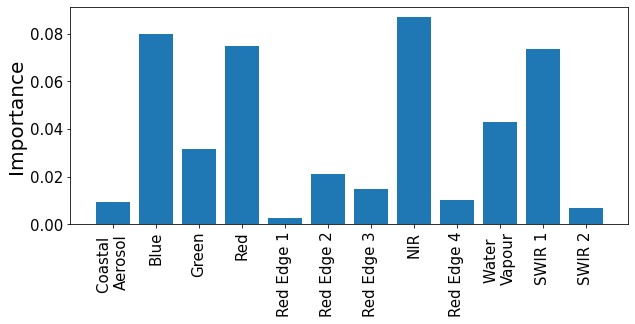

In [253]:
fig, ax  = plt.subplots(figsize=(10,4))
fig.set_facecolor('white')

plt.bar(height=change_acc,x=np.arange(0,12),)

plt.ylabel("Importance",size=20)

channels_ = ['Coastal \nAerosol','Blue','Green',
            'Red','Red Edge 1','Red Edge 2',
        'Red Edge 3','NIR','Red Edge 4',
            'Water \nVapour','SWIR 1','SWIR 2']

ax.set_xticks(np.arange(0,12),channels_,rotation=90, size=15)
plt.yticks(size=15)

plt.savefig(fig_path.format("importance"),bbox_inches='tight')

In [ ]:
import torch

# Assume that `model` is an instance of the UNet model, and `x` is a batch of input images
# with shape (batch_size, 12, H, W) where H and W are the height and width of the images

# Make sure the model is in eval mode
model.eval()

# Compute the model's output for the input images
output = model(images)

In [30]:
# Set up a gradient tensor with the same shape as the input
grad = torch.zeros_like(images).to(device)

# Compute the gradients of the output with respect to the input
output.backward(gradient=grad)

# Compute the feature importance scores as the average absolute gradient for each band
importance_scores = grad.abs().mean(dim=(0, 2, 3))

print(importance_scores)

RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([32, 12, 256, 256]) and output[0] has a shape of torch.Size([32, 1, 256, 256]).

# Archive 

In [ ]:
def load_train(path):
    """Returns sentinal image, rgb image and label"""
    
    label_path = path.replace("images","labels").replace("image","chip")
   
    img = np.load(path)
    rgb_img = get_rgb(img)
    label = np.load(label_path)[0]
    
    return img, rgb_img, label


def load_test(path):
    """Returns sentinal image, rgb image and label"""
    
    img = gdal.Open(path).ReadAsArray()
    stack_img = np.stack(img, axis=-1)
    rgb_img = get_rgb(stack_img)
    
    label_path = path.replace("images","labels").replace("image","label")
    label = gdal.Open(label_path).ReadAsArray()
    
    return stack_img, rgb_img, label

In [ ]:

def conv_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,)
    return model


def conv_trans_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,)
    return model


def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block_2(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

def conv_block_3(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        conv_block(out_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

class unet(nn.Module):
    def __init__(self, in_dim, out_dim, num_filter):
        super(unet, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        self.down_1 = conv_block_2(self.in_dim, self.num_filter, act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter * 1, self.num_filter * 2, act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter * 2, self.num_filter * 4, act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter * 4, self.num_filter * 8, act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter * 8, self.num_filter * 16, act_fn)

        self.trans_1 = conv_trans_block(self.num_filter * 16, self.num_filter * 8, act_fn)
        self.up_1 = conv_block_2(self.num_filter * 16, self.num_filter * 8, act_fn)
        self.trans_2 = conv_trans_block(self.num_filter * 8, self.num_filter * 4, act_fn)
        self.up_2 = conv_block_2(self.num_filter * 8, self.num_filter * 4, act_fn)
        self.trans_3 = conv_trans_block(self.num_filter * 4, self.num_filter * 2, act_fn)
        self.up_3 = conv_block_2(self.num_filter * 4, self.num_filter * 2, act_fn)
        self.trans_4 = conv_trans_block(self.num_filter * 2, self.num_filter * 1, act_fn)
        self.up_4 = conv_block_2(self.num_filter * 2, self.num_filter * 1, act_fn)

        self.out = nn.Sequential(nn.Conv2d(self.num_filter, self.out_dim, 3, 1, 1), nn.Tanh())

    def forward(self, input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1, down_4], dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2, down_3], dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3, down_2], dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4, down_1], dim=1)
        up_4 = self.up_4(concat_4)

        out = self.out(up_4)

        return out